In [254]:
import pandas as pd
import os
import plotly.express as px
import requests

In [240]:
#This data is downloaded using lego "grant_data_extract"
#Contains data for the current alpha round (generated as of 29th Jan)

DATA_PATH = '/Users/kk/Downloads/'
df_grant_applications = pd.read_csv(os.path.join(DATA_PATH,"grant_applications.csv"))
df_grant_votes = pd.read_csv(os.path.join(DATA_PATH,"grant_votes.csv"))

# ADD amount in US

rq = requests.get('https://api.coingecko.com/api/v3/simple/price?ids=ethereum%2Cdai&vs_currencies=usd')
PRICE_INFO = rq.json()

def get_price(x):
    token = 'ethereum' if x['token'] == 'ETH' else x['token'].lower()
    return x['amount'] * PRICE_INFO[token]['usd']

df_grant_votes['amount_usd'] = df_grant_votes.apply(lambda x: get_price(x), axis=1)

print("Data points available in the grant_votes dataset:")
print("\n".join(list(df_grant_votes.columns)))


Data points available in the grant_votes dataset:
id
application_id
project_id
round
round_name
token
amount
source_wallet
destination_wallet
created_at_block
created_at
transaction_hash


In [ ]:
print( "{} votes received from {} contributors for {} projects".format(
    df_grant_votes.shape[0], 
    len(df_grant_votes.source_wallet.unique()),
    len(df_grant_votes.application_id.unique()),
))
print( "{} approved projects".format(
    len(df_grant_applications.id.unique())
))
print("-------------------")
print("There were few projects that are found in votes addition to the approved projects. Not sure of the reason. May be test/cancelled projects?")
print("-------------------")

print(set(df_grant_votes.application_id.unique()).difference(set(df_grant_applications.id.unique())))

print("--------------------")
df_grant_votes = df_grant_votes[df_grant_votes.application_id.isin(df_grant_applications.id)]

128285 votes received from 21010 contributors for 178 projects
159 approved projects
-------------------
There were few projects that are found in votes addition to the approved projects. Not sure of the reason. May be test/cancelled projects?
-------------------
{'0x9fb5b0d0698dc64cbd3a01c5205ebc5ef609e7d20c21ce20ee2c73905a8309a0-0x1b165fe4da6bc58ab8370ddc763d367d29f50ef0', '0x60c037f9dfa5daee0f07bc26fb73393ef924e36c73c41ea6bd58029e1724de36-0x1b165fe4da6bc58ab8370ddc763d367d29f50ef0', '0x79f3e178005bfbe0a3defff8693009bb12e58102763501e52995162820ae3560-0xd95a1969c41112cee9a2c931e849bcef36a16f4c', '0x429927c3a14cbe156749adb31371f385749150ac3604513b24d0ddfb6e7b8b90-0x1b165fe4da6bc58ab8370ddc763d367d29f50ef0', '0x8029c7cda58d70a6cd81ac56a6a678e8ccfb560f153eb86b1f5b5c3ca4566e82-0x1b165fe4da6bc58ab8370ddc763d367d29f50ef0', '0x13f8b39159680f9e0bc9aebebb09c978d9c02060b55d9c5224a6c6fbaf8572bf-0xd95a1969c41112cee9a2c931e849bcef36a16f4c', '0x99b81016d61f8b9115282b1055649d4876f38619759064b7834780

<AxesSubplot:>

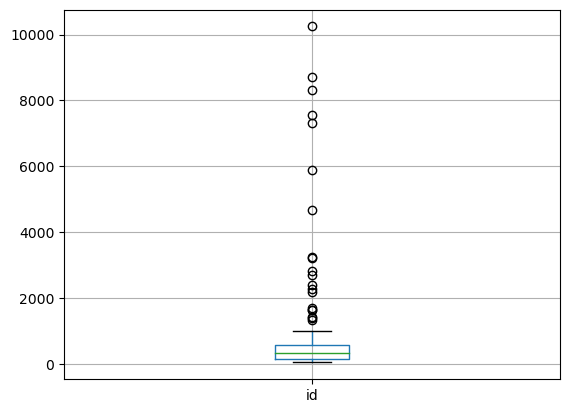

In [244]:
pd.DataFrame(df_grant_votes.groupby(["application_id"])["id"].count()).boxplot()

##### out of the 159 projects, The above plot shows the distribution of votes to different projects
##### Few projects have received a substantial number of high votes, which could indicate either their popularity or the presence of a sybil attack
##### To further expand, one option is to categorize projects into similar clusters or groups based on similarity, which can be determined by category or popularity (Twitter followers)


### 1. Examine the reason for high voting in certain projects.

OSS round seems to have large number of outliers than others


<AxesSubplot:title={'center':'votes_count'}, xlabel='[round_name]'>

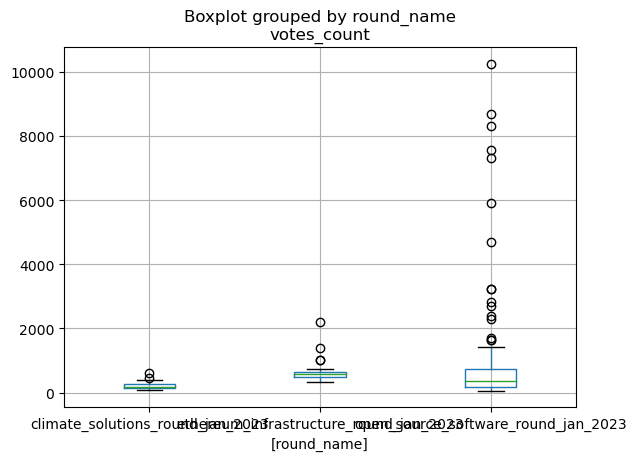

In [245]:
df_grouped_1 = df_grant_votes.groupby(["application_id","round_name"])["id"].count().reset_index()
df_grouped_1.columns = ['application_id','round_name','votes_count']
print("OSS round seems to have large number of outliers than others")
df_grouped_1.boxplot(column=['votes_count'],by=['round_name'])

In [259]:
df_grouped_1_v1 = df_grouped_1.merge(df_grant_applications[["id","project_twitter","twitter_followers"]], left_on="application_id", right_on="id")

from IPython.display import display, Markdown, Latex

import plotly.express as px

for round in df_grouped_1_v1.round_name.unique():
    display(Markdown('### {}'.format(round.upper())))
    mask = df_grouped_1_v1.round_name==round
    fig = px.scatter(df_grouped_1_v1[mask], x="votes_count", y="twitter_followers", hover_name="project_twitter",
        hover_data= ["votes_count", "twitter_followers"])
    fig.show()


### CLIMATE_SOLUTIONS_ROUND_JAN_2023

### ETHEREUM_INFRASTRUCTURE_ROUND_JAN_2023

### OPEN_SOURCE_SOFTWARE_ROUND_JAN_2023

#### Imbalance in followers/votes is apparent in few cases

#### For eg

#### WaterDAO has 62 followers but received over 400 votes.
#### Lenster has got over 10K votes with 30K followers 

#### Let's define a simple metric (votes/followers) to automatically surface such imbalances to investigate them further
 


In [255]:
#Add Amount
df_grouped_2 = df_grant_votes.groupby(["application_id"])["amount_usd"].sum().reset_index()
df_grouped_2.columns = ["application_id","amount_usd"]
df_grouped_1_v2 = df_grouped_1_v1.merge(df_grouped_2, on="application_id")

df_grouped_1_v2['metric_twitter_votes_ratio'] = df_grouped_1_v2['votes_count'] / df_grouped_1_v2['twitter_followers']


fig = px.histogram(df_grouped_1_v2, x="metric_twitter_votes_ratio")
fig.show()


In [274]:
#LOOK AT ALL accounts whose twitter_followers are less than their votes
df_grouped_1_v2[df_grouped_1_v2.metric_twitter_votes_ratio > 0.5].sort_values('metric_twitter_votes_ratio', ascending=False)[
    ['project_twitter','votes_count','amount_usd','twitter_followers','metric_twitter_votes_ratio']].head(20)

,project_twitter,votes_count,amount_usd,twitter_followers,metric_twitter_votes_ratio
81,zkrepl,745,1347.450772,30.0,24.833333
69,smol_evm,325,1047.105849,19.0,17.105263
64,@_WaterDAO,469,2068.482135,62.0,7.564516
27,ActNow_Bundle,149,565.772890,20.0,7.450000
145,projects_unite,147,446.261472,24.0,6.125000
22,OptiNames,2708,7246.156473,526.0,5.148289
52,vvlovsky,224,774.638516,44.0,5.090909
82,verif_infra,166,698.312182,46.0,3.608696
29,0xDeadList,222,451.011934,63.0,3.523810
53,kovart_dev,357,671.232367,102.0,3.500000


#### Projects like zkrepl, smol_evm, and @_WaterDAO have received more votes compared to other projects with similar number of followers.
#### What may be the reason? Examining their wallets may provide further insights.

In [268]:


#Let's look at @_WaterDAO which has 469 votes
#Twitter account created in Dec 2022 with 18 followers & 469 gtc votes but why were other projects with significant followers were not able to get that number?
def get_project_by_twitter(twitter):
    return df_grouped_1_v2[df_grouped_1_v2.project_twitter==twitter]['application_id'].head(1).values[0]


def check_wallets_of_project_of_interest(project_twitter):
    #poi - project of interest
    poi_id = get_project_by_twitter(project_twitter)

    #get wallets that only contributed to WaterDAO
    other_wallets = set(df_grant_votes[df_grant_votes.application_id!= poi_id].source_wallet.unique())
    poi_wallets = set(df_grant_votes[df_grant_votes.application_id==poi_id].source_wallet.unique())

    display(Markdown("### Total wallets contributed to {}: {}".format(project_twitter, len(poi_wallets))))
    display(Markdown("### wallets that contributed only to {}: {}".format(project_twitter, len(poi_wallets.difference(other_wallets)))))

    print("----------")
    display(Markdown("### other projects that the same {} wallets contributed to:".format(project_twitter)))
    poi_wallets_other_contributions_too = poi_wallets.intersection(other_wallets)
    df_votes_by_poi_wallets_to_other_projects = df_grant_votes[df_grant_votes.source_wallet.isin(poi_wallets_other_contributions_too)].groupby(["application_id"])["id"].count().reset_index()
    df_votes_by_poi_wallets_to_other_projects.columns = ['application_id','total_votes']
    interesting_other_projects = df_votes_by_poi_wallets_to_other_projects[df_votes_by_poi_wallets_to_other_projects.total_votes>100].application_id
    return df_grouped_1_v2[df_grouped_1_v2.application_id.isin(interesting_other_projects)].sort_values('metric_twitter_votes_ratio', ascending=False).head(10)

check_wallets_of_project_of_interest('zkrepl')


### Total wallets contributed to zkrepl: 726

### wallets that contributed only to zkrepl: 6

----------


### other projects that the same zkrepl wallets contributed to:

,application_id,round_name,votes_count,id,project_twitter,twitter_followers,amount_usd,metric_twitter_votes_ratio
81,0x958a27cbbf604752b32e4593aa7d3801d5de011248d5...,open_source_software_round_jan_2023,745,0x958a27cbbf604752b32e4593aa7d3801d5de011248d5...,zkrepl,30.0,1347.450772,24.833333
22,0x3e4b3f7089aa5cb6614b67e235624d01364febe41841...,open_source_software_round_jan_2023,2708,0x3e4b3f7089aa5cb6614b67e235624d01364febe41841...,OptiNames,526.0,7246.156473,5.148289
127,0xcc6d33fe291d0fafb19cf8b833dc27d2f469fac52e3c...,open_source_software_round_jan_2023,1702,0xcc6d33fe291d0fafb19cf8b833dc27d2f469fac52e3c...,glorylaboratory,2135.0,3857.901070,0.797190
78,0x91db8779fa1b15d75761e358fe57683892c68d5cad11...,open_source_software_round_jan_2023,3214,0x91db8779fa1b15d75761e358fe57683892c68d5cad11...,pohdao,4382.0,6487.648342,0.733455
154,0xf22becdb87631f44c3cf5839e471811ed21c4200324c...,open_source_software_round_jan_2023,2385,0xf22becdb87631f44c3cf5839e471811ed21c4200324c...,MetaMailInk,3278.0,4328.980191,0.727578
21,0x3b839e762e389f72b3c43b70aeb7bb5c43a3781feda8...,open_source_software_round_jan_2023,2284,0x3b839e762e389f72b3c43b70aeb7bb5c43a3781feda8...,loansharktech,3289.0,6607.935979,0.694436
129,0xd3bd2111f80027d538cc252a13afacad8eb0b1565a58...,open_source_software_round_jan_2023,436,0xd3bd2111f80027d538cc252a13afacad8eb0b1565a58...,https://twitter.com/GitcoinCN,662.0,807.247259,0.658610
3,0x0d1d9c4e5785c2d5e3cb1df956dfec6cc3f3729d64cf...,open_source_software_round_jan_2023,381,0x0d1d9c4e5785c2d5e3cb1df956dfec6cc3f3729d64cf...,skywinder,806.0,1127.144383,0.472705
76,0x8b4c72d7b905fe5f514970024119ae06c4d97a5b1a1a...,open_source_software_round_jan_2023,490,0x8b4c72d7b905fe5f514970024119ae06c4d97a5b1a1a...,realScamSniffer,1071.0,892.199789,0.457516
92,0x9fb5b0d0698dc64cbd3a01c5205ebc5ef609e7d20c21...,open_source_software_round_jan_2023,3235,0x9fb5b0d0698dc64cbd3a01c5205ebc5ef609e7d20c21...,umbracash,7733.0,9415.660334,0.418337


In [269]:
check_wallets_of_project_of_interest('smol_evm')

### Total wallets contributed to smol_evm: 317

### wallets that contributed only to smol_evm: 9

----------


### other projects that the same smol_evm wallets contributed to:

,application_id,round_name,votes_count,id,project_twitter,twitter_followers,amount_usd,metric_twitter_votes_ratio
69,0x7e9c8fa1694bdebd30515fb4ccebd4eb6a5a4f489228...,ethereum_infrastructure_round_jan_2023,325,0x7e9c8fa1694bdebd30515fb4ccebd4eb6a5a4f489228...,smol_evm,19.0,1047.105849,17.105263
22,0x3e4b3f7089aa5cb6614b67e235624d01364febe41841...,open_source_software_round_jan_2023,2708,0x3e4b3f7089aa5cb6614b67e235624d01364febe41841...,OptiNames,526.0,7246.156473,5.148289
66,0x7a8072161b166f17d280a4427fdac169f9dab2426ca1...,ethereum_infrastructure_round_jan_2023,1001,0x7a8072161b166f17d280a4427fdac169f9dab2426ca1...,DanieleSalatti,996.0,5139.495071,1.005020
78,0x91db8779fa1b15d75761e358fe57683892c68d5cad11...,open_source_software_round_jan_2023,3214,0x91db8779fa1b15d75761e358fe57683892c68d5cad11...,pohdao,4382.0,6487.648342,0.733455
2,0x0cdbfe30f8bfea9a33a297e1812c0ff146d326a3afa5...,ethereum_infrastructure_round_jan_2023,567,0x0cdbfe30f8bfea9a33a297e1812c0ff146d326a3afa5...,otterscan,787.0,3203.990450,0.720457
112,0xb901109e1791c6a48f7315a198536a9e2211834e3fe4...,ethereum_infrastructure_round_jan_2023,577,0xb901109e1791c6a48f7315a198536a9e2211834e3fe4...,lodestar_eth,861.0,1543.091724,0.670151
99,0xaa09ef03fe5e4d9a0aa3d49a203ea8d1d89969e19cfe...,ethereum_infrastructure_round_jan_2023,423,0xaa09ef03fe5e4d9a0aa3d49a203ea8d1d89969e19cfe...,stereumdev,718.0,1307.867145,0.589136
84,0x99b81016d61f8b9115282b1055649d4876f386197590...,ethereum_infrastructure_round_jan_2023,657,0x99b81016d61f8b9115282b1055649d4876f386197590...,NiceNodeApp,1270.0,2225.979945,0.517323
89,0x9cf538295b69125db2e7036df4bee5d9f40ce2966577...,ethereum_infrastructure_round_jan_2023,375,0x9cf538295b69125db2e7036df4bee5d9f40ce2966577...,yush_g,847.0,951.875116,0.442739
92,0x9fb5b0d0698dc64cbd3a01c5205ebc5ef609e7d20c21...,open_source_software_round_jan_2023,3235,0x9fb5b0d0698dc64cbd3a01c5205ebc5ef609e7d20c21...,umbracash,7733.0,9415.660334,0.418337


In [270]:
check_wallets_of_project_of_interest('@_WaterDAO')

### Total wallets contributed to @_WaterDAO: 453

### wallets that contributed only to @_WaterDAO: 15

----------


### other projects that the same @_WaterDAO wallets contributed to:

,application_id,round_name,votes_count,id,project_twitter,twitter_followers,amount_usd,metric_twitter_votes_ratio
64,0x78b858009ecfa46c866a7765cf0665699dd097eaadc3...,climate_solutions_round_jan_2023,469,0x78b858009ecfa46c866a7765cf0665699dd097eaadc3...,@_WaterDAO,62.0,2068.482135,7.564516
22,0x3e4b3f7089aa5cb6614b67e235624d01364febe41841...,open_source_software_round_jan_2023,2708,0x3e4b3f7089aa5cb6614b67e235624d01364febe41841...,OptiNames,526.0,7246.156473,5.148289
25,0x42799cfce3b14376285e960875ef687cd7d1b32439a2...,climate_solutions_round_jan_2023,392,0x42799cfce3b14376285e960875ef687cd7d1b32439a2...,solar_FND,138.0,1881.211166,2.840580
0,0x0299d145933e3abc9bee2251589d080e0b12765e7e21...,climate_solutions_round_jan_2023,354,0x0299d145933e3abc9bee2251589d080e0b12765e7e21...,SolarpunkNomads,180.0,1562.790793,1.966667
66,0x7a8072161b166f17d280a4427fdac169f9dab2426ca1...,ethereum_infrastructure_round_jan_2023,1001,0x7a8072161b166f17d280a4427fdac169f9dab2426ca1...,DanieleSalatti,996.0,5139.495071,1.005020
127,0xcc6d33fe291d0fafb19cf8b833dc27d2f469fac52e3c...,open_source_software_round_jan_2023,1702,0xcc6d33fe291d0fafb19cf8b833dc27d2f469fac52e3c...,glorylaboratory,2135.0,3857.901070,0.797190
78,0x91db8779fa1b15d75761e358fe57683892c68d5cad11...,open_source_software_round_jan_2023,3214,0x91db8779fa1b15d75761e358fe57683892c68d5cad11...,pohdao,4382.0,6487.648342,0.733455
154,0xf22becdb87631f44c3cf5839e471811ed21c4200324c...,open_source_software_round_jan_2023,2385,0xf22becdb87631f44c3cf5839e471811ed21c4200324c...,MetaMailInk,3278.0,4328.980191,0.727578
21,0x3b839e762e389f72b3c43b70aeb7bb5c43a3781feda8...,open_source_software_round_jan_2023,2284,0x3b839e762e389f72b3c43b70aeb7bb5c43a3781feda8...,loansharktech,3289.0,6607.935979,0.694436
112,0xb901109e1791c6a48f7315a198536a9e2211834e3fe4...,ethereum_infrastructure_round_jan_2023,577,0xb901109e1791c6a48f7315a198536a9e2211834e3fe4...,lodestar_eth,861.0,1543.091724,0.670151


#### In all of the cases above, if we consider the wallets that ONLY contributed to the project, then it roughly correlates with their twitter followers
#### Then who are the other wallets and what led them to choose these projects over others?
#### There seems to be no simple explanation for that and requires further investigation or combining with other insights
#### Adding this metric "twitter_votes_ratio" atleast would allow the analyst to discover such projects/wallets and investigate them further